 # Augmentations in NLP

Data Augmentation techniques in NLP show substantial improvements on datasets with less than 500 observations, as illustrated by the original paper.

https://arxiv.org/abs/1901.11196

The Paper Considered here is EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks




In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  ***Simple Data Augmentatons Techniques* are:**
1. SR : Synonym Replacement 
2. RD : Random Deletion
3. RS : Random Swap
4. RI : Random Insertion



In [ ]:
data = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')

In [ ]:
data.head()

In [ ]:
list_to_drop = ['textID','selected_text','sentiment']
data.drop(list_to_drop,axis=1,inplace=True)

In [ ]:
data.head()

In [ ]:
print(f"Total number of examples to be used is : {len(data)}")

# 1. Synonym Replacement :

Synonym replacement is a technique in which we replace a word by one of its synonyms

For identifying relevent Synonyms we use WordNet

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

The get_synonyms funtion will return pre-processed list of synonyms of given word

Now we will replace the words with synonyms

In [ ]:
from nltk.corpus import stopwords
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)
print(stop_words)

In [ ]:
import random


In [ ]:

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence


In [ ]:
print(f" Example of Synonym Replacement: {synonym_replacement('hey man how are you doing',3)}")

To Get Larger Diversity of Sentences we could try replacing 1,2 3, .. Words in the given sentence.

Now lets get an example from out dataset and try augmenting it so that we could create 3 additional sentences per tweet 

In [ ]:
trial_sent = data['text'][np.random.randint(0,50)]
print(trial_sent)


In [ ]:
# Create 3 Augmented Sentences per data 

for n in range(3):
    print(f" Example of Synonym Replacement: {synonym_replacement(trial_sent,n)}")

Now we are able to augment this Data :)

You can create New colums for the Same text-id  in our tweet - sentiment Dataset

# 2.Random Deletion (RD)

In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. This allows for a random deletion of some words of the sentence.



In [ ]:
def random_deletion(words, p):

    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

Lets test out this Augmentation with our test_sample

In [ ]:
print(random_deletion(trial_sent,0.2))
print(random_deletion(trial_sent,0.3))
print(random_deletion(trial_sent,0.4))

This Could help us in reducing Overfitting and may help to imporve our Model Accuracy 


# 3. Random Swap (RS)

In Random Swap, we randomly swap the order of two words in a sentence.


In [ ]:
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

# This will Swap the words



In [ ]:
def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    # n is the number of words to be swapped
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

In [ ]:
print(random_swap(trial_sent,1))
print(random_swap(trial_sent,2))
print(random_swap(trial_sent,3))

This Random Swapping will help to make our models robust and may inturn help in text classification. 

High order of swapping may downgrade the model

There is a high chance to loose semantics of language so be careful while using this augmentaion.



# 4. Random Insertion (RI)
Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.

Data augmentation
operations should not change the true label of
a sentence, as that would introduce unnecessary
noise into the data. Inserting a synonym of a word
in a sentence, opposed to a random word, is more
likely to be relevant to the context and retain the
original label of the sentence.

In [ ]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)


In [ ]:
print(random_insertion(trial_sent,1))
print(random_insertion(trial_sent,2))
print(random_insertion(trial_sent,3))

In [ ]:
def aug(sent,n,p):
    print(f" Original Sentence : {sent}")
    print(f" SR Augmented Sentence : {synonym_replacement(sent,n)}")
    print(f" RD Augmented Sentence : {random_deletion(sent,p)}")
    print(f" RS Augmented Sentence : {random_swap(sent,n)}")
    print(f" RI Augmented Sentence : {random_insertion(sent,n)}")
    
    

In [ ]:
aug(trial_sent,4,0.3)

In [ ]:
print(f" RI Augmented Sentence : {random_insertion(trial_sent,n)}")

The above Line Shows the Augmentations possible 

We covered the main Data Augmentation techniques in NLP. This is an active field of research, and the papers about this topic are quite recent.

Link to Paper : https://arxiv.org/abs/1901.11196

Repo Link : https://github.com/jasonwei20/eda_nlp


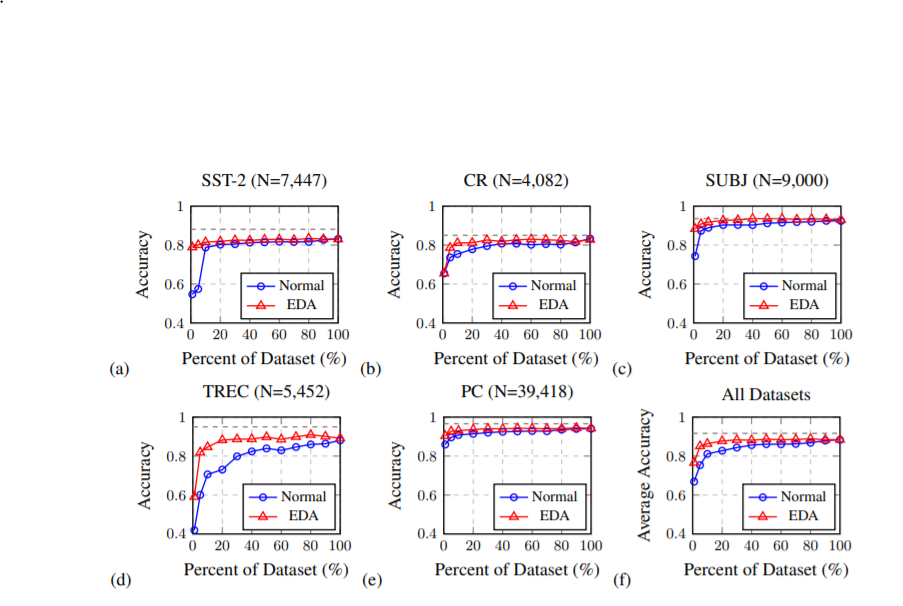

# Final Thoughts Regarding EDA:




* EDA might not help much if you’re using a large enough dataset.

* Models that have been pre-trained on massive datasets probably don’t need EDA. So in most of the Cases Transformer Based Models wont require EDA

* generating augmented data similar to original data introduces some degree of noise that helps prevent overfitting. This may give a clearn understanding , why augmenation helps in making robust models.

* EDA can introduce new vocabulary through the synonym replacement and random insertion operations, allowing models to generalize to words in the test set that were not in the training set. 

* Finally this effects are more pronounced for smaller datasets.  


Open to new ideas and Suggestions and hope you were able to learn something Good. 

*Thank you so much for Reading the Kernal*   !!

